In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd
from matplotlib.colors import LogNorm
import pandas as pd
import geopandas as gpd
from libpysal import weights
from esda import Moran, Geary
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot
import calendar 

In [2]:
# Load the datasets
def load_data():
    train_df = pd.read_csv('../data/raw/Train.csv')
    waste_df = pd.read_csv('../data/raw/waste_management.csv')
    toilets_df = pd.read_csv('../data/raw/toilets.csv')
    water_df = pd.read_csv('../data/raw/water_sources.csv')
    return train_df, waste_df, toilets_df, water_df

train_df, waste_df, toilets_df, water_df = load_data()

In [25]:
def plot_disease_distribution(train_df, disease, year, month):
    """
    Visualize the spatial distribution of a specific disease for a given year and month.
    Applies a log transformation to the 'Total' column for better visualization.
    Includes a colorbar for the log scale.
    """
    # Filter data for the specified disease, year, and month
    filtered_df = train_df[(train_df['Disease'] == disease) & 
                           (train_df['Year'] == year) & 
                           (train_df['Month'] == month)]
    
    # Apply log transformation to the 'Total' column
    filtered_df['Total_log'] = np.log1p(filtered_df['Total'])  # log1p(x) = log(x + 1)
    
    # Plot spatial distribution with log-transformed values
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(filtered_df['Transformed_Longitude'], filtered_df['Transformed_Latitude'], 
                          c=filtered_df['Total_log'], cmap='Reds', alpha=0.8, s=filtered_df['Total_log'] * 20)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, label='Log(Outbreaks + 1)')
    cbar.set_ticks([0, 1, 2, 3, 4])  # Customize ticks for log scale
    cbar.set_ticklabels(['0', '1', '2', '3', '4'])  # Corresponding labels
    
    plt.title(f"Spatial Distribution of {disease} Outbreaks ({calendar.month_name[month]} {year})")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_locations(train_df, water_df, waste_df, toilets_df, year=2022, month=1, month_name='January'):
    """
    Visualize locations for a specific year and month
    Note: months/year should be in the given timeframe [2019, 2023]
    """
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in calendar.month_name[1:]:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(15, 10))  # Slightly larger figure
    
    # Define subsets with colors and better visibility
    subsets = [
        (train_df.query(f"Year == {year} and Month == {month}"), 
         'Transformed', 'Hospital', 's', '#FF3333'),  # Brighter red
        (water_df.query(f"Month_Year == '{month}_{year}'"), 
         'Transformed', 'Water', 'o', '#9933FF'),     # Brighter purple
        (waste_df.query(f"Month_Year == '{month}_{year}'"), 
         'Transformed', 'Waste', 'x', '#33CC33'),     # Brighter green
        (toilets_df.query(f"Month_Year == '{month}_{year}'"), 
         'Transformed', 'Toilet', '^', '#3399FF')     # Brighter blue
    ]
    
    # Plot each subset with enhanced visibility
    for df, prefix, label, marker, color in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], 
                   df[f'{prefix}_Latitude'], 
                   label=label, 
                   alpha=0.7,     # Slightly increased alpha
                   marker=marker,
                   c=color,
                   s=120,        # Slightly larger markers
                   edgecolors='white',  # White edges for better contrast
                   linewidth=0.5)
    
    plt.title(f'Locations ({month_name.capitalize()} {year})', fontsize=14, pad=20)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(fontsize=10, markerscale=1.5)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
def calculate_spatial_autocorrelation(train_df, disease, year, month, k=10, threshold=None):
    """
    Calculate Moran's I and Geary's C for a specific disease, year, and month.

    Parameters:
        train_df (pd.DataFrame): The training dataset.
        disease (str): The disease to analyze.
        year (int): The year to filter by.
        month (int): The month to filter by.
        k (int): Number of neighbors for KNN weights. Default is 10.
        threshold (float): Distance threshold for DistanceBand weights. If None, KNN is used.

    Returns:
        moran_i (float): Moran's I value.
        geary_c (float): Geary's C value.
    """
    # Filter data for the specified disease, year, and month
    filtered_df = train_df[(train_df['Disease'] == disease) & 
                           (train_df['Year'] == year) & 
                           (train_df['Month'] == month)]
    
    # Drop rows with missing coordinates or target variable
    filtered_df = filtered_df.dropna(subset=['Transformed_Latitude', 'Transformed_Longitude', 'Total'])

    # Aggregate data over locations (sum of 'Total' per location)
    aggregated_df = filtered_df.groupby(['Transformed_Latitude', 'Transformed_Longitude']).agg({'Total': 'sum'}).reset_index()

    # Convert to GeoDataFrame
    train_gdf = gpd.GeoDataFrame(aggregated_df, 
                                 geometry=gpd.points_from_xy(aggregated_df.Transformed_Longitude, aggregated_df.Transformed_Latitude),
                                 crs="EPSG:4326")

    # Ensure the target variable is numeric
    train_gdf['Total'] = pd.to_numeric(train_gdf['Total'], errors='coerce')

    # Create spatial weights matrix
    if threshold:
        w = weights.DistanceBand.from_dataframe(train_gdf, threshold=threshold)
    else:
        w = weights.KNN.from_dataframe(train_gdf, k=k)
    w.transform = 'r'  # Row-standardization

    # Check for disconnected components
    disconnected = w.islands
    if disconnected:
        print(f"Disconnected components detected: {len(disconnected)}")
        # Try increasing k to reduce disconnected components
        while disconnected and k < len(train_gdf):
            k += 1
            w = weights.KNN.from_dataframe(train_gdf, k=k)
            w.transform = 'r'
            disconnected = w.islands
        print(f"Adjusted k to {k} to ensure connectivity")

    # Extract the 'Total' column values
    values = train_gdf['Total'].values

    # Calculate Moran's I
    moran = esda.Moran(values, w)
    moran_i = moran.I

    # Calculate Geary's C
    geary = esda.Geary(values, w)
    geary_c = geary.C

    # Print results
    print(f"Moran's I: {moran_i}")
    print(f"Geary's C: {geary_c}")

    # Plot Moran's I Scatterplot
    fig, ax = moran_scatterplot(moran)
    plt.title(f"Moran's I Scatterplot - {disease} ({calendar.month_name[month]} {year})")
    plt.show()

    return moran_i, geary_c

C:\Users\meddh\AppData\Local\Temp\ipykernel_14216\494209536.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Total_log'] = np.log1p(filtered_df['Total'])  # log1p(x) = log(x + 1)


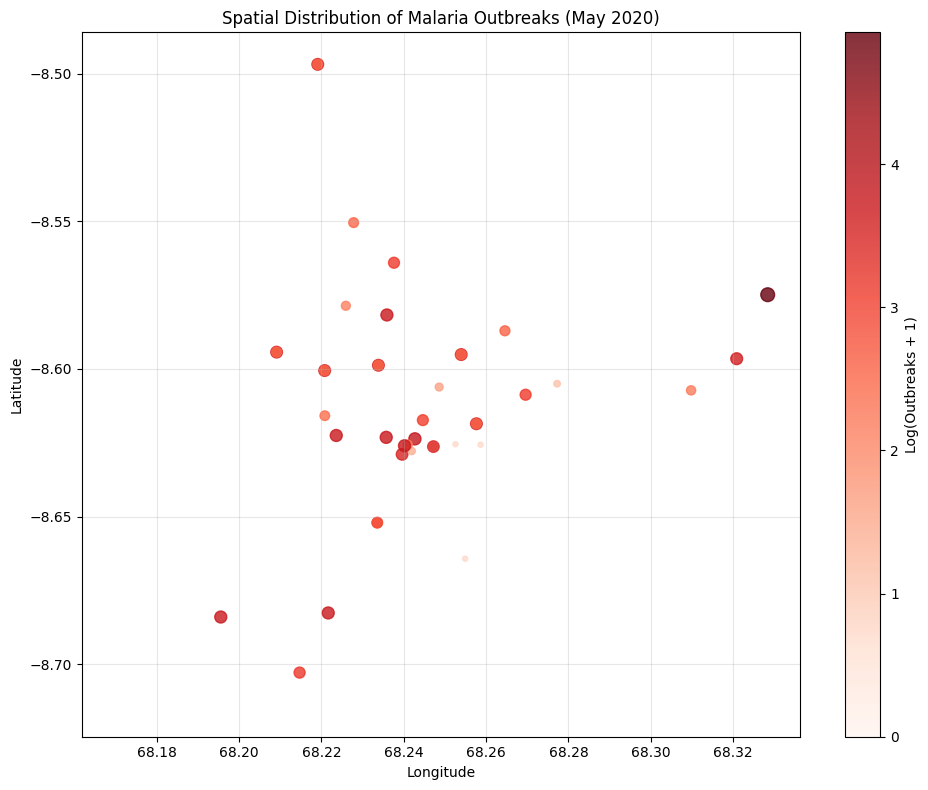

In [30]:
# Example 1: Visualize Malaria outbreaks in December 2020
plot_disease_distribution(train_df, disease="Malaria", year=2020, month=5)

C:\Users\meddh\AppData\Local\Temp\ipykernel_14216\3440537629.py:34: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(df[f'{prefix}_Longitude'],


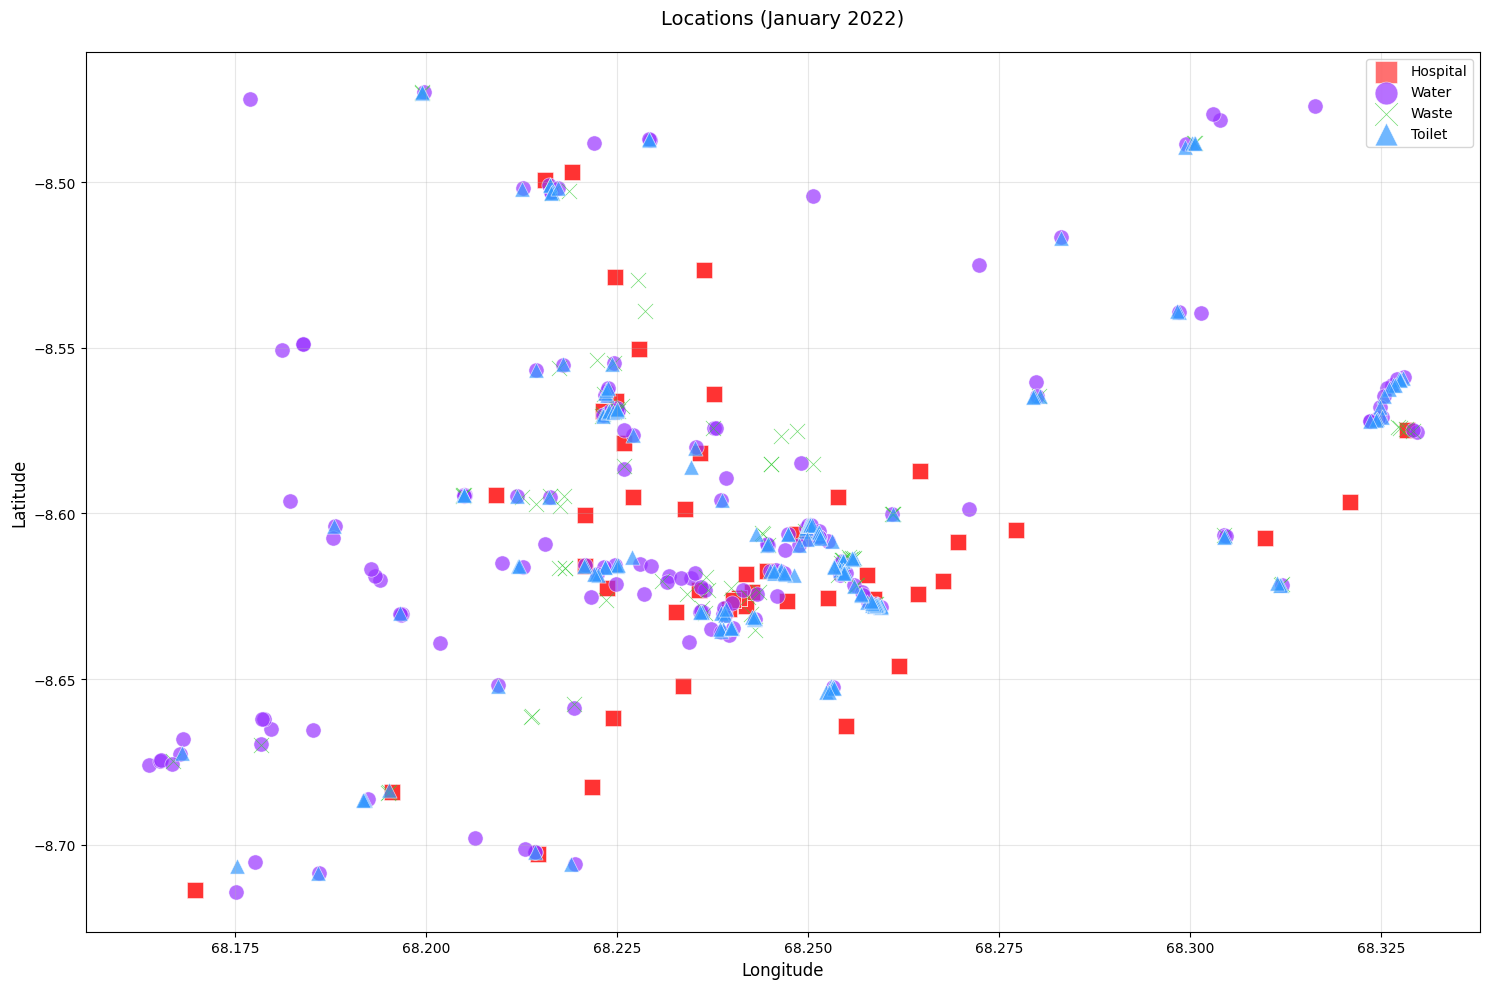

In [9]:
# Example 2: Plot locations of water, waste, and toilets in January 2022
plot_locations(train_df, water_df, waste_df, toilets_df, year=2022, month=1)

Moran's I: 0.04015943641082686
Geary's C: 0.9038955541430516


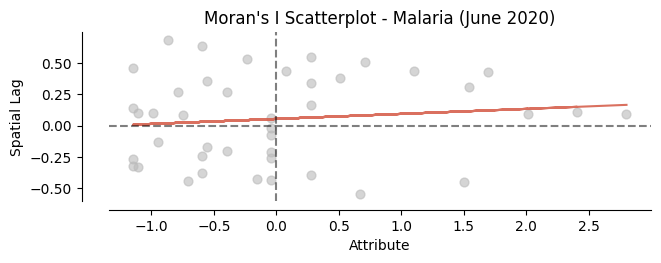

In [36]:
# Example 3: Calculate spatial autocorrelation for Malaria in December 2020
moran_i, geary_c = calculate_spatial_autocorrelation(train_df, disease="Malaria", year=2020, month=6 ,k=10, threshold=None)